*Note part 3, the discussion, is touched throughout the lab, but separately addressed at the end*

In [437]:
#imports
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score
from plotnine import ggplot, geom_boxplot, aes, labs, geom_point, geom_line

In [421]:
data = pd.read_csv("Hitters.csv")
data.head()
#if the salary column is NaN, we will drop that row as that is the variable to be predicted 
#if one of the other columns is NaN, we will replace it with the mean of that column so the data from the other columns can be used 

Data_drop_NA = data.dropna(subset = "Salary")

data_clean = Data_drop_NA.apply(lambda x: x.fillna(x.mean()) if x.dtype in ['float64', 'int64'] else x)
data_clean.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [111]:
# data_clean["Division"].unique()

**Pipeline 1**
All columns as predictor for salary using basic linear regression


In [57]:
X = data_clean.drop("Salary", axis = 1)
y = data_clean["Salary"]
#League, division, and NewLeague are categorical and need to be dummified

In [154]:
ct_1 = ColumnTransformer(
    [("dummify", OneHotEncoder(sparse_output= False, drop= "first"),  make_column_selector(dtype_include=object)),
    ("standardize", StandardScaler(), make_column_selector(dtype_include= np.number))
    ],
    remainder = "passthrough"
).set_output(transform = "pandas")
variables = ct_1.fit_transform(data_clean)
# variables

In [54]:
pipeline_1 = Pipeline(
    [("preprocessing", ct_1),
    ("Regression", LinearRegression())]
).set_output(transform= "pandas")

Interpretting some important coeffecients of model 1:

In [385]:
#fitting to full dataset 
pipeline_1_fitted = pipeline_1.fit(X, y)
coeff = pipeline_1_fitted.named_steps['Regression'].coef_
variable = variables.columns
variable = variable[0:19]
important_variables = pd.DataFrame({"Variables" : variable, "Coeffecients" : coeff, "Absolute Value" : abs(coeff)})
important_variables.sort_values("Absolute Value", ascending= False).head()

,Variables,Coeffecients,Absolute Value
13,standardize__CRuns,480.747135,480.747135
10,standardize__CAtBat,-391.038655,391.038655
4,standardize__Hits,337.830479,337.830479
3,standardize__AtBat,-291.094556,291.094556
14,standardize__CRBI,260.689886,260.689886


When sorting the coeffecients based on their absolute value, the top five most important coeffecients are: the number of career runs, the number of career at bats, the number of hits in 1986, the number of at bats in 1986, and the number of career RBIs. Career runs, 1986 hits, and career RBIs are the highest positive coeffecients. This means that if you are a player with lots of runs and RBIs throughout your career and hit well in 1986 your salary will likely be higher. 

On the other side it seems that career at bats and 1986 at bats negatively correlate to a higher salary in 1989. This seems odd at first glance and I am curious to see how this changes as some other variables are dropped, however in this model, a higher amount of at bats seems to mean a lower salary for the 1989 season. I notice that career years also has a negative correlation, so potentially older players who have more at bats are outside of the "prime" age to play and these variables are also showing that. 

**MSE scores for pipeline 1:**

In [310]:
scores = -cross_val_score(pipeline_1, X, y, cv=5, scoring='neg_mean_squared_error') 
#chat GPT helped to write "neg_mean_squared_error", to evaluate based on mse vs. r2
pipeline_1_MSE = scores.mean()
print(pipeline_1_MSE)

121136.31031816886
121136.31031816886


**Pipeline 2**
All columns as predictor for salary using ridge regression

In [104]:
pipeline_2 = Pipeline(
    [("preprocessing", ct_1),
    ("Regression", Ridge())]
).set_output(transform= "pandas")
params = {
    'Regression__alpha': np.logspace(-5, 5, num = 11)
}

gscv = GridSearchCV(pipeline_2, params, cv =5, scoring = 'r2')

In [158]:
gscv_fitted = gscv.fit(X, y)

gscv_fitted.cv_results_

pd.DataFrame(data = {"Alpha": np.logspace(-5, 5, num = 11), "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).head(1)

#the best alpha is 100

,Alpha,scores
7,100.0,0.384293


In [106]:
pipeline_2_best = Pipeline(
    [("preprocessing", ct_1),
    ("Regression", Ridge(alpha= 100))]
).set_output(transform= "pandas")

In [232]:
#fitting to full dataset 
pipeline_2_fitted = pipeline_2_best.fit(X, y)
coeff_2 = pipeline_2_fitted.named_steps['Regression'].coef_
important_variables_ridge = pd.DataFrame({"Variables" : variable, "Coeffecients" : coeff_2, "Absolute Value" : abs(coeff_2)})
important_variables_ridge.sort_values("Absolute Value", ascending= False).head(6)

,Variables,Coeffecients,Absolute Value
16,standardize__PutOuts,57.151970,57.151970
1,dummify__Division_W,-53.025407,53.025407
4,standardize__Hits,49.783252,49.783252
14,standardize__CRBI,46.964067,46.964067
13,standardize__CRuns,45.812163,45.812163
11,standardize__CHits,44.468686,44.468686


According to this regression model, the most important variables in determining 1989 salary are the number of defensive put outs recorded in 1986, Division in 1986, number of hits in 1986, number of career RBIs and number of career runs. 

These values seem to make much more sense as all are positively correlated with 1989 salary, except division West. This means that the players in the east division were on average making 53,000 more dollars than their equal counterparts in the west division. The players who were one standard deviation above the mean for 1986 outs, hits and career rbis and runs made on average 57, 50, 47, and 46 thousand dollars more than their equal counterparts, according to this regression model.

**MSE scores for pipeline 2:**

In [171]:
scores_2 = - cross_val_score(pipeline_2_best, X, y, cv=5, scoring='neg_mean_squared_error')
pipeline_2_MSE = scores_2.mean()
print(pipeline_2_MSE)

121274.42407036023
121274.42407036023


**Pipeline 3**
All columns as predictor for salary using Lasso regression

In [163]:
pipeline_3 = Pipeline(
    [("preprocessing", ct_1),
    ("Regression", Lasso())]
).set_output(transform= "pandas")
params = {
    'Regression__alpha': np.logspace(-5, 5, num = 11)
}

gscv_3 = GridSearchCV(pipeline_3, params, cv =5, scoring = 'r2')

In [164]:
# gscv_3_fitted = gscv_3.fit(X, y)

# gscv_3_fitted.cv_results_

pd.DataFrame(data = {"Alpha": np.logspace(-5, 5, num = 11), "scores": gscv_3_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).head(1)

#the best alpha is 10

,Alpha,scores
6,10.0,0.369523


In [233]:
pipeline_3_best = Pipeline(
    [("preprocessing", ct_1),
    ("Regression", Lasso(alpha= 10))]
).set_output(transform= "pandas")

#fitting to full dataset 
pipeline_3_fitted = pipeline_3_best.fit(X, y)
coeff_3 = pipeline_3_fitted.named_steps['Regression'].coef_
important_variables_lasso = pd.DataFrame({"Variables" : variable, "Coeffecients" : coeff_3, "Absolute Value" : abs(coeff_3)})
important_variables_lasso.sort_values("Absolute Value", ascending= False).head(6)

,Variables,Coeffecients,Absolute Value
14,standardize__CRBI,134.032027,134.032027
1,dummify__Division_W,-95.413203,95.413203
4,standardize__Hits,88.741627,88.741627
13,standardize__CRuns,72.227529,72.227529
16,standardize__PutOuts,66.737006,66.737006
8,standardize__Walks,49.902813,49.902813


In the Lasso regression model, only 7 variables came out with a non-zero coeffecient. The top 5 variables are the same as from the ridge model, however in differing orders and values. There is still a large difference between the salaries predicted for players in the east divison vs. the west division (95,000 greater in the east). Career RBIs seem to be the most important variable with players at one standard deviation above the mean predicted to earn about 134,000 more than equal counterparts with average number of RBIs. Hits, careeer runs, and put outs are also used as positive predictors for a greater salary when above the average in each category. 

**MSE scores for pipeline 3:**

In [170]:
scores_3= - cross_val_score(pipeline_3_best, X, y, cv=5, scoring='neg_mean_squared_error')
pipeline_3_MSE = scores_3.mean()
print(pipeline_3_MSE)

121828.14133338635
121828.14133338635


**Pipeline 4**
All columns as predictor for salary using Elastic Net regression

In [125]:
pipeline_4 = Pipeline(
    [("preprocessing", ct_1),
    ("Regression", ElasticNet())]
).set_output(transform= "pandas")
params = {
    'Regression__alpha': np.logspace(-5, 5, num = 11),
    'Regression__l1_ratio' : np.linspace(0,1, num = 5)
}

gscv_4 = GridSearchCV(pipeline_4, params, cv =5, scoring = 'r2')

In [137]:
# gscv_4_fitted = gscv_4.fit(X, y)
# gscv_4_fitted.cv_results_
pd.DataFrame(data = {"specifications": gscv_4_fitted.cv_results_['params'], "scores": gscv_4_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).head(1)
#{'Regression__alpha': 1.0, 'Regression__l1_ratio': 0.25}

,specifications,scores
26,"{'Regression__alpha': 1.0, 'Regression__l1_rat...",0.384872


In [234]:
pipeline_4_best = Pipeline(
    [("preprocessing", ct_1),
    ("Regression", ElasticNet(alpha= 1, l1_ratio= 0.25))]
).set_output(transform= "pandas")

#fitting to full dataset 
pipeline_4_fitted = pipeline_4_best.fit(X, y)
coeff_4 = pipeline_4_fitted.named_steps['Regression'].coef_
important_variables_elastic_net = pd.DataFrame({"Variables" : variable, "Coeffecients" : coeff_4, "Absolute Value" : abs(coeff_4)})
important_variables_elastic_net.sort_values("Absolute Value", ascending= False).head()

,Variables,Coeffecients,Absolute Value
16,standardize__PutOuts,46.140698,46.140698
14,standardize__CRBI,38.483120,38.483120
4,standardize__Hits,38.419543,38.419543
13,standardize__CRuns,37.725747,37.725747
11,standardize__CHits,36.749044,36.749044


Based on the Elastic Net model, the top five most important variables based on their coeffecients are defensive put outs in 1986, career Rbi's, hits in 1986, career runs, and career hits. For every standard deviation above the mean in these categories a player is predicted to earn between 46,000 and 37,000 more dollars in 1989. 


**MSE scores for pipeline 4:**

In [169]:
scores_4= - cross_val_score(pipeline_4_best, X, y, cv=5, scoring='neg_mean_squared_error')
pipeline_4_MSE = scores_4.mean()
print(pipeline_4_MSE)

122065.0128350202
122065.0128350202


In [241]:
#comparing important variables across datasets, first must standardize the coeffecients to compare variable effects across models
 
Standardize = ColumnTransformer(
    [
    ("standardize", StandardScaler(), ["Coeffecients"]),
    ("", FunctionTransformer(None), ["Variables"])
    ], remainder= "drop"
).set_output(transform= "pandas")

C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [257]:
variables_std = Standardize.fit_transform(important_variables)
variables_ridge_std= Standardize.fit_transform(important_variables_ridge)
variables_lasso_std = Standardize.fit_transform(important_variables_lasso)
variables_elastic_std = Standardize.fit_transform(important_variables_elastic_net)

In [268]:
#joining dataset
all_variables_std = (
    variables_std.merge(variables_ridge_std, on="__Variables", suffixes=('_lin', '_ridge'))
       .merge(variables_lasso_std, on="__Variables", suffixes=('_linridge', '_lasso'))
       .merge(variables_elastic_std, on="__Variables", suffixes=('_linridgelasso', '_elastic'))
)


all_variables_std["sum"]= ( all_variables_std["standardize__Coeffecients_lin"].abs() 
    + all_variables_std["standardize__Coeffecients_ridge"].abs()
    + all_variables_std["standardize__Coeffecients_linridgelasso"].abs()
    + all_variables_std["standardize__Coeffecients_elastic"].abs())
all_variables_std.sort_values("sum", ascending=False).head(6)
#this shows that CRBIs is the single most valuable numeric variable, while division is the most valuable categorical.

,standardize__Coeffecients_lin,__Variables,standardize__Coeffecients_ridge,standardize__Coeffecients_linridgelasso,standardize__Coeffecients_elastic,sum
1,-0.682465,dummify__Division_W,-2.696803,-2.378824,-2.707567,8.465660
14,1.218052,standardize__CRBI,1.035229,2.501541,1.011072,5.765893
13,2.325811,standardize__CRuns,0.992235,1.186942,0.972103,5.477091
4,1.606374,standardize__Hits,1.140453,1.538201,1.007800,5.292829
16,0.302231,standardize__PutOuts,1.415484,1.070157,1.405068,4.192940
18,-0.205807,standardize__Errors,-1.212614,-0.437806,-1.395193,3.251420


Based on the above models, I would determine that the most important categorical variable is certainly Division in 1986. The top five most important numeric variables seem to include: Career Rbis, 1986 put outs, 1986 hits, career runs, and 1986 errors. The single most important numeric variable is Career Rbis. This is based on giving equal weight to each dataset and adding the importance of the variables in each dataset together. 


**Single variable models**

In [423]:
def Single_Numeric_Regression_Test(Df, Regression):
    """
    Returns the MSE value for a given dataset and regression type,
    The function can be slightly altered to return best alpha, coeffecients, or more
   

    Parameters
    ----------

    df: pandas.DataFrame
    Must be cleaned hitters dataset
    Regression: must be LinearRegression
    Ridge, Lasso, or ElasticNet

    Return
   ------
   MSE 
   a single numeric value
    
    """

    X = Df.drop("Salary", axis = 1)
    y = Df["Salary"]
    ct1v = ColumnTransformer(
        [
        ("standardize", StandardScaler(), ["CRBI"])
        ],
        remainder= "drop").set_output(transform= "pandas")

    pipeline_regression = Pipeline(
            [("preprocessing", ct1v),
            ("Regression", Regression())]
        ).set_output(transform= "pandas")


    if Regression == ElasticNet:
      params2 = {
          'Regression__alpha': np.logspace(-5, 5, num = 11),
          'Regression__l1_ratio' : np.linspace(0,1, num = 5)
          }

      gscv = GridSearchCV(pipeline_regression, params2, cv =5, scoring = 'r2')
      gscv_fitted = gscv.fit(X, y)  
      best_alpha = pd.DataFrame(data = {"alpha": gscv_fitted.cv_results_['param_Regression__alpha'], "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]
      best_l1 = pd.DataFrame(data = {"l1_ratio": gscv_fitted.cv_results_['param_Regression__l1_ratio'], "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]
      pipeline_best = Pipeline(
        [("preprocessing", ct1v),
        ("Regression", Regression(alpha = best_alpha, l1_ratio = best_l1))]
      ).set_output(transform= "pandas")


    elif Regression == Lasso or Regression == Ridge: 
      params = {
          'Regression__alpha': np.logspace(-5, 5, num = 11)
          }
      gscv = GridSearchCV(pipeline_regression, params, cv =5, scoring = 'r2')
      gscv_fitted= gscv.fit(X, y)
      best_alpha = pd.DataFrame(data = {"Alpha": np.logspace(-5, 5, num = 11), "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]
      pipeline_best = Pipeline(
        [("preprocessing", ct1v),
        ("Regression", Regression(alpha = best_alpha))]
      ).set_output(transform= "pandas")

    elif Regression == LinearRegression:
          pipeline_best = pipeline_regression
          best_alpha = "No Alpha"

    scores_regression = -cross_val_score(pipeline_best, X, y, cv=5, scoring='neg_mean_squared_error') 
    regression_MSE = scores_regression.mean()
    
    return regression_MSE

*Stanard Linear Regression Model*

In [414]:
LR_1_MSE = Single_Numeric_Regression_Test(data_clean, LinearRegression)
print(LR_1_MSE)

142142.865462403
142142.865462403


In [415]:
R_1_MSE = Single_Numeric_Regression_Test(data_clean, Ridge)
print(R_1_MSE)

142096.24206102983
142096.24206102983


In [416]:
L_1_MSE = Single_Numeric_Regression_Test(data_clean, Lasso)
print(L_1_MSE)

142236.17109795552
142236.17109795552


In [419]:
E_1_MSE = Single_Numeric_Regression_Test(data_clean, ElasticNet)
print(E_1_MSE)

142182.01290223506
142182.01290223506


**Top Five Numeric Variable Models**
*Crbis, putouts, hits, errors, cruns*


In [424]:
def Five_Numeric_Regression_Test(Df, Regression):
    """
    Returns the MSE value using regression on the five most important numeric variables for a given dataset and regression type,
    The function can be slightly altered to return best alpha, coeffecients, or more
   

    Parameters
    ----------

    df: pandas.DataFrame
    Must be cleaned hitters dataset
    Regression: must be LinearRegression
    Ridge, Lasso, or ElasticNet

    Return
   ------
   MSE 
   a single numeric value
    
    """

    X = Df.drop("Salary", axis = 1)
    y = Df["Salary"]
    ct5v = ColumnTransformer(
        [
        ("standardize", StandardScaler(), ["CRBI", "PutOuts", "Hits", "Errors", "CRuns"])
        ],
        remainder= "drop").set_output(transform= "pandas")

    pipeline_regression = Pipeline(
            [("preprocessing", ct5v),
            ("Regression", Regression())]
        ).set_output(transform= "pandas")


    if Regression == ElasticNet:
      params2 = {
          'Regression__alpha': np.logspace(-5, 5, num = 11),
          'Regression__l1_ratio' : np.linspace(0,1, num = 5)
          }

      gscv = GridSearchCV(pipeline_regression, params2, cv =5, scoring = 'r2')
      gscv_fitted = gscv.fit(X, y)  
      best_alpha = pd.DataFrame(data = {"alpha": gscv_fitted.cv_results_['param_Regression__alpha'], "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]
      best_l1 = pd.DataFrame(data = {"l1_ratio": gscv_fitted.cv_results_['param_Regression__l1_ratio'], "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]
      pipeline_best = Pipeline(
        [("preprocessing", ct5v),
        ("Regression", Regression(alpha = best_alpha, l1_ratio = best_l1))]
      ).set_output(transform= "pandas")


    elif Regression == Lasso or Regression == Ridge: 
      params = {
          'Regression__alpha': np.logspace(-5, 5, num = 11)
          }
      gscv = GridSearchCV(pipeline_regression, params, cv =5, scoring = 'r2')
      gscv_fitted= gscv.fit(X, y)
      best_alpha = pd.DataFrame(data = {"Alpha": np.logspace(-5, 5, num = 11), "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]
      pipeline_best = Pipeline(
        [("preprocessing", ct5v),
        ("Regression", Regression(alpha = best_alpha))]
      ).set_output(transform= "pandas")

    elif Regression == LinearRegression:
          pipeline_best = pipeline_regression
          best_alpha = "No Alpha"

    scores_regression = -cross_val_score(pipeline_best, X, y, cv=5, scoring='neg_mean_squared_error') 
    regression_MSE = scores_regression.mean()
    
    return regression_MSE

*Standard Linear Regression*

In [406]:
LR_5_MSE = Five_Numeric_Regression_Test(data_clean, LinearRegression)
print(LR_5_MSE)

123085.29627318266
123085.29627318266


*Ridge Regression Model*

In [407]:
R_5_MSE = Five_Numeric_Regression_Test(data_clean, Ridge)
print(R_5_MSE)

122298.62066042508
122298.62066042508


*Lasso Regression Model*

In [408]:
L_5_MSE= Five_Numeric_Regression_Test(data_clean, Lasso)
print(L_5_MSE)

123502.18685078024
123502.18685078024


*Elastic Net*

In [277]:
E_5_MSE = Five_Numeric_Regression_Test(data_clean, ElasticNet)
print(E_5_MSE)

121197.74758274996
121197.74758274996


**Top Five Numeric Variables and their Interaction with Categorical Variable**

In [425]:
def Five_Numeric_Regression_Interaction_Test(Df, Regression):
    """
    Returns the MSE value for a given dataset and regression type using the five most important numeric values and the most important categorical interaction,
    The function can be slightly altered to return best alpha, coeffecients, or more
   

    Parameters
    ----------

    df: pandas.DataFrame
    Must be cleaned hitters dataset
    Regression: must be LinearRegression
    Ridge, Lasso, or ElasticNet

    Return
   ------
   MSE 
   a single numeric value
    
    """

    X = Df.drop("Salary", axis = 1)
    y = Df["Salary"]
    ct5vi = ColumnTransformer(
        [
        ("standardize", StandardScaler(), ["CRBI", "PutOuts", "Hits", "Errors", "CRuns"]),
        ("dummify", OneHotEncoder(sparse_output= False, drop = "first"), ["Division"])
        ],
        remainder= "drop").set_output(transform= "pandas")
    ct_interaction= ColumnTransformer(
        [
            ("interaction1", PolynomialFeatures(interaction_only= True, include_bias= False), ["standardize__CRBI", "dummify__Division_W"]),
            ("interaction2", PolynomialFeatures(interaction_only= True, include_bias= False), ["standardize__PutOuts", "dummify__Division_W"]),
            ("interaction3", PolynomialFeatures(interaction_only= True, include_bias= False), ["standardize__Hits", "dummify__Division_W"]),
            ("interaction4", PolynomialFeatures(interaction_only= True, include_bias= False), ["standardize__Errors", "dummify__Division_W"]),
            ("interaction5", PolynomialFeatures(interaction_only= True, include_bias= False), ["standardize__CRuns", "dummify__Division_W"])

        ],
        remainder= "drop").set_output(transform= "pandas")
    
    ct_keep = ColumnTransformer(
      [
        ("keep", FunctionTransformer(None), ["interaction1__standardize__CRBI", "interaction1__dummify__Division_W", "interaction1__standardize__CRBI dummify__Division_W", "interaction2__standardize__PutOuts", "interaction2__standardize__PutOuts dummify__Division_W", "interaction3__standardize__Hits", "interaction3__standardize__Hits dummify__Division_W", "interaction4__standardize__Errors", "interaction4__standardize__Errors dummify__Division_W", "interaction5__standardize__CRuns", "interaction5__standardize__CRuns dummify__Division_W"])
      ],
      remainder= "drop").set_output(transform= "pandas")


    pipeline_regression = Pipeline(
            [("preprocessing", ct5vi),
            ("interaction", ct_interaction),
            ("keep", ct_keep),
            ("Regression", Regression())]
        ).set_output(transform= "pandas")


    if Regression == ElasticNet:
      params2 = {
          'Regression__alpha': np.logspace(-5, 5, num = 11),
          'Regression__l1_ratio' : np.linspace(0,1, num = 5)
          }

      gscv = GridSearchCV(pipeline_regression, params2, cv =5, scoring = 'r2')
      gscv_fitted = gscv.fit(X, y)  
      best_alpha_elastic = pd.DataFrame(data = {"alpha": gscv_fitted.cv_results_['param_Regression__alpha'], "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]
      best_l1_elastic = pd.DataFrame(data = {"l1_ratio": gscv_fitted.cv_results_['param_Regression__l1_ratio'], "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]
      pipeline_best = Pipeline(
        [("preprocessing", ct5vi),
        ("interaction", ct_interaction),
        ("keep", ct_keep),
        ("Regression", Regression(alpha = best_alpha_elastic, l1_ratio = best_l1_elastic))]
      ).set_output(transform= "pandas")


    elif Regression == Lasso or Regression == Ridge: 
      params = {
          'Regression__alpha': np.logspace(-5, 5, num = 11)
          }
      gscv = GridSearchCV(pipeline_regression, params, cv =5, scoring = 'r2')
      gscv_fitted= gscv.fit(X, y)
      best_alpha = pd.DataFrame(data = {"Alpha": np.logspace(-5, 5, num = 11), "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]
      pipeline_best = Pipeline(
        [("preprocessing", ct5vi),
        ("interaction", ct_interaction),
        ("keep", ct_keep),
        ("Regression", Regression(alpha = best_alpha))]
      ).set_output(transform= "pandas")

    elif Regression == LinearRegression:
          pipeline_best = pipeline_regression

    scores_regression = -cross_val_score(pipeline_best, X, y, cv=5, scoring='neg_mean_squared_error') 
    regression_MSE = scores_regression.mean()
    
    return regression_MSE

In [ ]:
# def Five_Numeric_Regression_Interaction_Test(Df):
#     X = Df.drop("Salary", axis = 1)
#     y = Df["Salary"]
#     ct5v = ColumnTransformer(
#         [
#         ("standardize", StandardScaler(), ["CRBI", "PutOuts", "Hits", "CHits", "CRuns"]),
#         ("dummify", )
#         ],
#         remainder= "drop").set_output(transform= "pandas")

#     pipeline_linear = Pipeline(
#             [("preprocessing", ct5v),
#             ("Regression", LinearRegression())]
#         ).set_output(transform= "pandas")
  
#     #finding MSE
#     scores_linear = -cross_val_score(pipeline_linear, X, y, cv=5, scoring='neg_mean_squared_error') 
#     linear_MSE = scores_5v_Lr.mean()

#    #Tuning for Ridge and Lasso
#     params = {
#     'Regression__alpha': np.logspace(-5, 5, num = 11)
#     }

#     pipeline_ridge= Pipeline(
#       [("preprocessing", ct5v),
#       ("Regression", Ridge())]
#     ).set_output(transform= "pandas")

#     gscv_ridge = GridSearchCV(pipeline_ridge, params, cv =5, scoring = 'r2')
#     gscv_ridge_fitted = gscv_ridge.fit(X, y)
#     best_alpha_ridge = pd.DataFrame(data = {"Alpha": np.logspace(-5, 5, num = 11), "scores": gscv_ridge_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]

#     pipeline_ridge_best = Pipeline(
#       [("preprocessing", ct5v),
#       ("Regression", Ridge(alpha = best_alpha_ridge))]
#     ).set_output(transform = "pandas")

#     #MSE scores ridge
#     scores_ridge = - cross_val_score(pipeline_ridge_best, X, y, cv=5, scoring = 'neg_mean_squared_error')
#     ridge_MSE = scores_ridge.mean()
#     #Lasso

#     pipeline_lasso = Pipeline(
#       [("preprocessing", ct5v), 
#        ("Regression", Lasso())]
#     ).set_output(transform= "pandas")

#     gscv_lasso = GridSearchCV(pipeline_lasso, params, cv =5, scoring = 'r2')
#     gscv_lasso_fitted = gscv_lasso.fit(X, y)
#     best_alpha_lasso = pd.DataFrame(data = {"Alpha": np.logspace(-5, 5, num = 11), "scores": gscv_lasso_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]

#     pipeline_lasso_best = Pipeline(
#       [("preprocessing", ct5v),
#       ("Regression", Ridge(alpha = best_alpha_lasso))]
#     ).set_output(transform = "pandas")

#     #MSE scores Lasso
#     scores_lasso = - cross_val_score(pipeline_lasso_best, X, y, cv=5, scoring = 'neg_mean_squared_error')
#     lasso_MSE = scores_lasso.mean()

#     #Elastic Net params:

#     params2 = {
#     'Regression__alpha': np.logspace(-5, 5, num = 11),
#     'Regression__l1_ratio' : np.linspace(0,1, num = 5)
#     }
#     #elastic Net
#     pipeline_elastic_net = Pipeline(
#       [("preprocessing", ct5v),
#       ("Regression", ElasticNet())]
#     ).set_output(transform= "pandas")

#     gscv_elastic_net = GridSearchCV(pipeline_elastic_net, params2, cv =5, scoring = 'r2')
#     gscv_elastic_net_fitted = gscv_elastic_net.fit(X, y)

#     best_alpha_elastic = pd.DataFrame(data = {"alpha": gscv_4_fitted.cv_results_['param_Regression__alpha'], "scores": gscv_4_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]
#     best_l1_elastic = pd.DataFrame(data = {"l1_ratio": gscv_4_fitted.cv_results_['param_Regression__l1_ratio'], "scores": gscv_4_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]

    
#     pipeline_elastic_net_best = Pipeline(
#       [("preprocessing", ct5v),
#       ("Regression", ElasticNet(alpha = best_alpha_elastic, l1_ratio = best_l1_elastic))]
#     ).set_output(transform = "pandas")

#     #MSE scores elastic
#     scores_elastic = - cross_val_score(pipeline_elastic_net_best, X, y, cv=5, scoring = 'neg_mean_squared_error')
#     elastic_MSE = scores_elastic.mean()

#     MSE_df = pd.DataFrame({"Model" : ["Linear Regression", "Ridge", "Lasso", "Elastic Net"], "MSE" : [linear_MSE, ridge_MSE, lasso_MSE, elastic_MSE]}).sort_values(by = "MSE", ascending = True)
#     return(MSE_df)

*Linear Regression*

In [286]:
LR_5I_MSE = Five_Numeric_Regression_Interaction_Test(data_clean, LinearRegression)
print(LR_5I_MSE)

131377.84385441605
131377.84385441605


*Ridge*

In [285]:
R_5I_MSE = Five_Numeric_Regression_Interaction_Test(data_clean, Ridge)
print(R_5I_MSE)

121503.530688711
121503.530688711


*Lasso*

In [282]:
L_5I_MSE = Five_Numeric_Regression_Interaction_Test(data_clean, Lasso)
print(L_5I_MSE)

120734.97563358131
120734.97563358131


*Elastic Net*

In [284]:
E_5I_MSE = Five_Numeric_Regression_Interaction_Test(data_clean, ElasticNet)
print(E_5I_MSE)

119038.112161515
119038.112161515


**Best Overall Model**

To Determine the best overall model, I will find which of these models has the lowest average 5 cross fold MSE.
To do so I will make a pandas dataframe. 

In [312]:
ModelMSEs = pd.DataFrame({
    "Model" : ["All_LR", "All_Ridge", "All_Lasso", "All_Elastic", "Single_LR", "Single_Ridge", 
    "Single_Lasso", "Single_Elastic", "Five_LR", "Five_Ridge", "Five_Lasso", "Five_Elastic", "Interaction_LR",
    "Interaction_Ridge", "Interaction_Lasso", "Interaction_Elastic"], 
    "MSE" : [pipeline_1_MSE, pipeline_2_MSE, pipeline_3_MSE, pipeline_4_MSE, LR_1_MSE, R_1_MSE, L_1_MSE, E_1_MSE, 
    LR_5_MSE, R_5_MSE, L_5_MSE, E_5_MSE, LR_5I_MSE, R_5I_MSE, L_5I_MSE, E_5I_MSE] })

In [315]:
ModelMSEs.sort_values("MSE", ascending= True)

,Model,MSE
15,Interaction_Elastic,119038.112162
14,Interaction_Lasso,120734.975634
0,All_LR,121136.310318
11,Five_Elastic,121197.747583
1,All_Ridge,121274.424070
13,Interaction_Ridge,121503.530689
2,All_Lasso,121828.141333
3,All_Elastic,122065.012835
9,Five_Ridge,122298.620660
8,Five_LR,123085.296273


The top model is the Interaction Elastic Model!

Lets take a look at the coeffecients associated with this model.

In [434]:
#slightly changing the code in the function to return coeffectients fit on the whole dataset

def Interaction_Coeffecients(Df, Regression):
  """
    Returns coeffecients for the interaction model with their associated variables
    The function can be slightly altered to return best alpha, coeffecients, or more
   

    Parameters
    ----------

    df: pandas.DataFrame
    Must be cleaned hitters dataset
    Regression: must be LinearRegression
    Ridge, Lasso, or ElasticNet

    Return
   ------
   Coeffecients
   a dataframe with the variables and their coeffecients
    
  """

  X = Df.drop("Salary", axis = 1)
  y = Df["Salary"]
  ct5vi = ColumnTransformer(
      [
      ("standardize", StandardScaler(), ["CRBI", "PutOuts", "Hits", "Errors", "CRuns"]),
      ("dummify", OneHotEncoder(sparse_output= False, drop = "first"), ["Division"])
      ],        remainder= "drop").set_output(transform= "pandas")
  ct_interaction= ColumnTransformer(
      [            ("interaction1", PolynomialFeatures(interaction_only= True, include_bias= False), ["standardize__CRBI", "dummify__Division_W"]),
           ("interaction2", PolynomialFeatures(interaction_only= True, include_bias= False), ["standardize__PutOuts", "dummify__Division_W"]),
          ("interaction3", PolynomialFeatures(interaction_only= True, include_bias= False), ["standardize__Hits", "dummify__Division_W"]),
          ("interaction4", PolynomialFeatures(interaction_only= True, include_bias= False), ["standardize__Errors", "dummify__Division_W"]),
          ("interaction5", PolynomialFeatures(interaction_only= True, include_bias= False), ["standardize__CRuns", "dummify__Division_W"])
      ],
      remainder= "drop").set_output(transform= "pandas")
    
  ct_keep = ColumnTransformer(
      [
        ("keep", FunctionTransformer(None), ["interaction1__standardize__CRBI", "interaction1__dummify__Division_W", "interaction1__standardize__CRBI dummify__Division_W", "interaction2__standardize__PutOuts", "interaction2__standardize__PutOuts dummify__Division_W", "interaction3__standardize__Hits", "interaction3__standardize__Hits dummify__Division_W", "interaction4__standardize__Errors", "interaction4__standardize__Errors dummify__Division_W", "interaction5__standardize__CRuns", "interaction5__standardize__CRuns dummify__Division_W"])
      ],
      remainder= "drop").set_output(transform= "pandas")


  pipeline_regression = Pipeline(
      [("preprocessing", ct5vi),
            ("interaction", ct_interaction),
      ("keep", ct_keep),
     ("Regression", Regression())]
      ).set_output(transform= "pandas")


  if Regression == ElasticNet:
    params2 = {
        'Regression__alpha': np.logspace(-5, 5, num = 11),
        'Regression__l1_ratio' : np.linspace(0,1, num = 5)
        }

    gscv = GridSearchCV(pipeline_regression, params2, cv =5, scoring = 'r2')
    gscv_fitted = gscv.fit(X, y)  
    best_alpha_elastic = pd.DataFrame(data = {"alpha": gscv_fitted.cv_results_['param_Regression__alpha'], "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]
    best_l1_elastic = pd.DataFrame(data = {"l1_ratio": gscv_fitted.cv_results_['param_Regression__l1_ratio'], "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]
    pipeline_best = Pipeline(
      [("preprocessing", ct5vi),        ("interaction", ct_interaction),
      ("keep", ct_keep),
      ("Regression", Regression(alpha = best_alpha_elastic, l1_ratio = best_l1_elastic))]
   ).set_output(transform= "pandas")


  elif Regression == Lasso or Regression == Ridge: 
    params = {
        'Regression__alpha': np.logspace(-5, 5, num = 11)
        }
    gscv = GridSearchCV(pipeline_regression, params, cv =5, scoring = 'r2')
    gscv_fitted= gscv.fit(X, y)
    best_alpha = pd.DataFrame(data = {"Alpha": np.logspace(-5, 5, num = 11), "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]
    pipeline_best = Pipeline(
      [("preprocessing", ct5vi),
      ("interaction", ct_interaction),
      ("keep", ct_keep),
      ("Regression", Regression(alpha = best_alpha))]
    ).set_output(transform= "pandas")

  elif Regression == LinearRegression:
      pipeline_best = pipeline_regression


    #fitting to full dataset 
  pipeline_fitted = pipeline_best.fit(X, y)
  coeff = pipeline_fitted.named_steps['Regression'].coef_
  Coeffecients_df= pd.DataFrame({"Variables" : ["interaction1__standardize__CRBI", "interaction1__dummify__Division_W",
   "interaction1__standardize__CRBI dummify__Division_W", "interaction2__standardize__PutOuts", "interaction2__standardize__PutOuts dummify__Division_W", 
   "interaction3__standardize__Hits", "interaction3__standardize__Hits dummify__Division_W", "interaction4__standardize__Errors",
    "interaction4__standardize__Errors dummify__Division_W", "interaction5__standardize__CRuns", "interaction5__standardize__CRuns dummify__Division_W"],
   "Coeffecients" : coeff})

  scores_regression = -cross_val_score(pipeline_best, X, y, cv=5, scoring='neg_mean_squared_error') 
  regression_MSE = scores_regression.mean()
    
  return Coeffecients_df.sort_values('Coeffecients', key = abs, ascending= False)

In [341]:
# Final_coeffecients = Interaction_Coeffecients(data_clean, ElasticNet)
Final_coeffecients

,Variables,Coeffecients
0,interaction1__standardize__CRBI,111.842289
9,interaction5__standardize__CRuns,104.200013
5,interaction3__standardize__Hits,101.831089
3,interaction2__standardize__PutOuts,72.985843
1,interaction1__dummify__Division_W,-68.036588
2,interaction1__standardize__CRBI dummify__Divis...,-17.014967
4,interaction2__standardize__PutOuts dummify__Di...,-11.364040
7,interaction4__standardize__Errors,-11.024620
10,interaction5__standardize__CRuns dummify__Divi...,-10.427252
6,interaction3__standardize__Hits dummify__Divis...,2.267586


Based on my best fitting model, the effect of career RBIs, Career Runs, and 1986 hits have the largest impact on Salary, with each standard deviation above the mean for these categories earning roughly 100,000 more dollars than their equal counter parts. 

In [438]:
#editing the function again to return a pd.series of y_preds 

def y_preds(Df, Regression):
    """
    Returns the given dataset with a new column filled with the predicted salaries for each "player" based on the interaction model
    and the data in the columns given
   

    Parameters
    ----------

    df: pandas.DataFrame
    Must be cleaned hitters dataset
    Regression: must be LinearRegression
    Ridge, Lasso, or ElasticNet

    Return
   ------
   Dataframe
   given dataframe with the new "Predictions" column
    """

    X = Df.drop("Salary", axis = 1)
    y = Df["Salary"]
    ct5vi = ColumnTransformer(
        [
        ("standardize", StandardScaler(), ["CRBI", "PutOuts", "Hits", "Errors", "CRuns"]),
        ("dummify", OneHotEncoder(sparse_output= False, drop = "first"), ["Division"])
        ],
        remainder= "drop").set_output(transform= "pandas")
    ct_interaction= ColumnTransformer(
        [
            ("interaction1", PolynomialFeatures(interaction_only= True, include_bias= False), ["standardize__CRBI", "dummify__Division_W"]),
            ("interaction2", PolynomialFeatures(interaction_only= True, include_bias= False), ["standardize__PutOuts", "dummify__Division_W"]),
            ("interaction3", PolynomialFeatures(interaction_only= True, include_bias= False), ["standardize__Hits", "dummify__Division_W"]),
            ("interaction4", PolynomialFeatures(interaction_only= True, include_bias= False), ["standardize__Errors", "dummify__Division_W"]),
            ("interaction5", PolynomialFeatures(interaction_only= True, include_bias= False), ["standardize__CRuns", "dummify__Division_W"])

        ],
        remainder= "drop").set_output(transform= "pandas")
    
    ct_keep = ColumnTransformer(
      [
        ("keep", FunctionTransformer(None), ["interaction1__standardize__CRBI", "interaction1__dummify__Division_W", "interaction1__standardize__CRBI dummify__Division_W", "interaction2__standardize__PutOuts", "interaction2__standardize__PutOuts dummify__Division_W", "interaction3__standardize__Hits", "interaction3__standardize__Hits dummify__Division_W", "interaction4__standardize__Errors", "interaction4__standardize__Errors dummify__Division_W", "interaction5__standardize__CRuns", "interaction5__standardize__CRuns dummify__Division_W"])
      ],
      remainder= "drop").set_output(transform= "pandas")


    pipeline_regression = Pipeline(
            [("preprocessing", ct5vi),
            ("interaction", ct_interaction),
            ("keep", ct_keep),
            ("Regression", Regression())]
        ).set_output(transform= "pandas")


    if Regression == ElasticNet:
      params2 = {
          'Regression__alpha': np.logspace(-5, 5, num = 11),
          'Regression__l1_ratio' : np.linspace(0,1, num = 5)
          }

      gscv = GridSearchCV(pipeline_regression, params2, cv =5, scoring = 'r2')
      gscv_fitted = gscv.fit(X, y)  
      best_alpha_elastic = pd.DataFrame(data = {"alpha": gscv_fitted.cv_results_['param_Regression__alpha'], "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]
      best_l1_elastic = pd.DataFrame(data = {"l1_ratio": gscv_fitted.cv_results_['param_Regression__l1_ratio'], "scores": gscv_fitted.cv_results_['mean_test_score']}).sort_values(by = "scores", ascending = False).iloc[0,0]
      pipeline_best = Pipeline(
        [("preprocessing", ct5vi),
        ("interaction", ct_interaction),
        ("keep", ct_keep),
        ("Regression", Regression(alpha = best_alpha_elastic, l1_ratio = best_l1_elastic))]
      ).set_output(transform= "pandas")

    #fitting to full dataset 
    pipeline_fitted = pipeline_best.fit(X, y)
    #salary_predictions
    Df["Predictions"] = pipeline_fitted.predict(X)
    
    return Df.head()

In [439]:
y_preds(data_clean, ElasticNet)

C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.156e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.728e+06, tolerance: 3.606e+03 L

C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.157e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.729e+06, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Dav

C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.159e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.739e+06, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Dav

C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.174e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.825e+06, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Dav

C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.269e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.042e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Dav

C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.643e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.289e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Dav

C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.165e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.661e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Dav

C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.331e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.786e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Dav

C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.351e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.801e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Dav

C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.354e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Dav

C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.354e+07, tolerance: 4.708e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.803e+07, tolerance: 3.606e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
C:\Users\Dav

C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,Predictions
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N,526.134647
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A,616.395970
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N,953.793404
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N,467.753730
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A,655.399958


In [371]:
ct_vis = ColumnTransformer(
    [("", FunctionTransformer(None), ["Salary", "Predictions"]),
    ("standardize", StandardScaler(), ["CRBI", "CRuns", "Hits"])
    ],
    remainder = "drop"
).set_output(transform = "pandas")
variables_vis = ct_vis.fit_transform(data_clean)
variables_vis["player"]= np.arange(1,264, 1) #this column is added in case theres multiple recordings of the same salary so information does not get lost 
# variables_vis


C:\Users\Davis\anaconda3\Lib\site-packages\sklearn\preprocessing\_function_transformer.py:345: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.


In [373]:
long_vis = variables_vis.melt(id_vars= ["player", "__Salary", "__Predictions"], var_name= "Predictor", value_vars= ["standardize__CRBI", "standardize__CRuns", "standardize__Hits"], value_name= "Standardized")

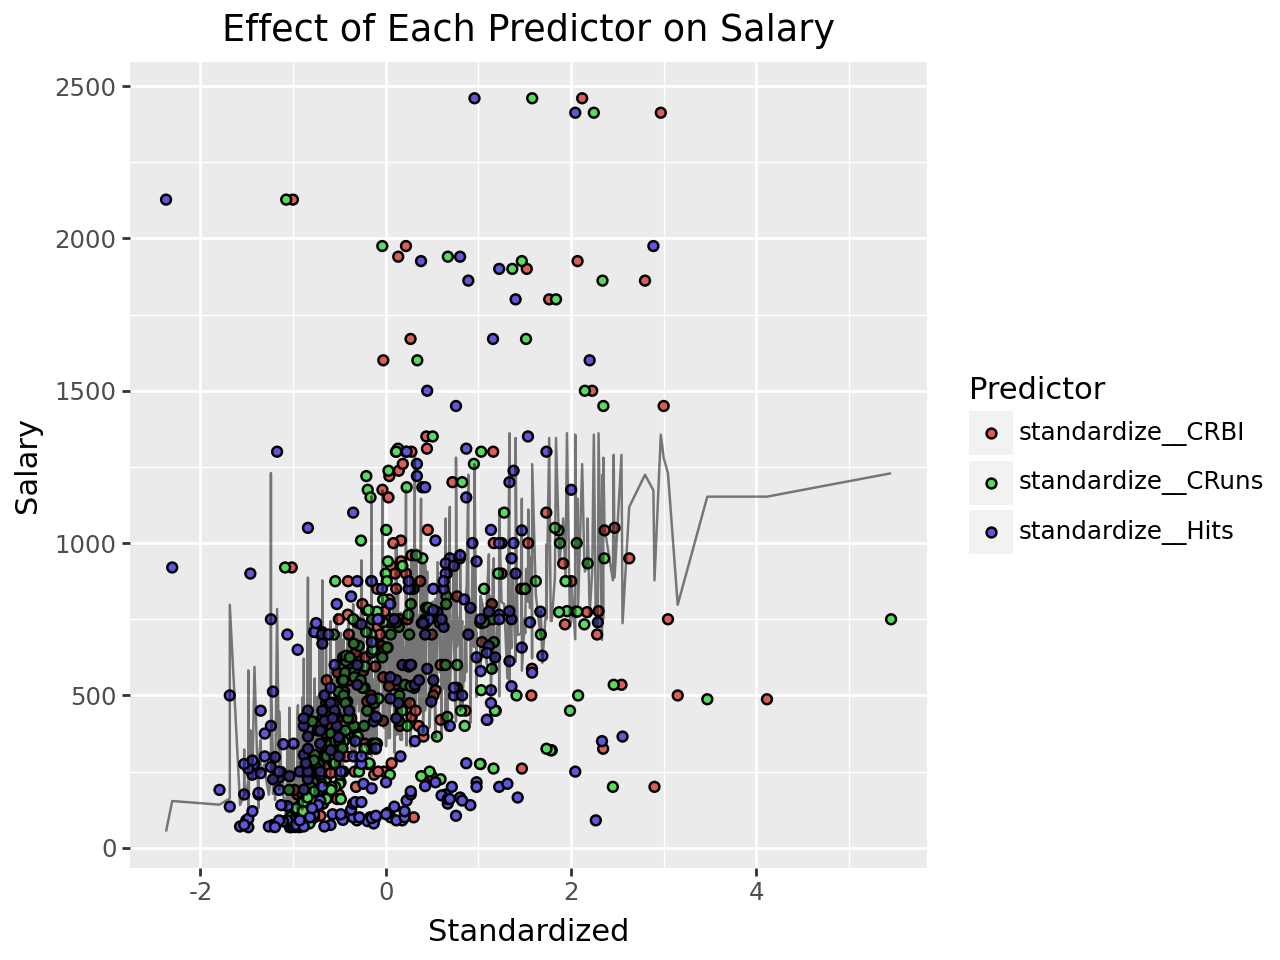

In [382]:
#Plot 

(ggplot(long_vis)  + geom_point(mapping= aes(x = "Standardized", y = "__Salary", fill = "Predictor"))+ geom_line(mapping= aes( x = "Standardized", y = "__Predictions"), alpha = 0.5)
+ labs(x="Standardized", y="Salary", title="Effect of Each Predictor on Salary"))


A clear positive corrleation can be seen in each of these variables. The predictor in my opinion seems to be extremely overfit to this dataset as well, but these variables do seem to have an impact salary. 

**PART III**

*Compare The ridge models to the ordinary regression models.*

The ridge coeffecients were spread more evenly and all much smaller on average than the standard linear coeffecients.

This makes sense because in Ridge the square of the coeffecients is the penalty so it really hates large coeffecients and would rather see many small coeffecients than one large one. 

*Compare your LASSO model in I with your three LASSO models in II. Did you get the same  lambda results? Why does this make sense? Did you get the same MSEs? Why does this make sense?*

Yes, The lambda value was 10.0 for every Lasso model. This makes sense because LASSO wants to limit the number of variables in general, so whether I am feeding it one or 5 variables it will produce a very similar model which favors the top variable the most anyways.

*Compare your MSEs for the Elastic Net models with those for the Ridge and LASSO models. Why does it make sense that Elastic Net always “wins”?*

Elastic Net MSE is lower in the interaction and top five variables. This makes sense because it is finding not only the best alpha like the other two models are, but also the best combination of the relationship between LASSO and Ridge. It makes sense it is going to beat those models because it is combining the best of each model into one.